# Minihack Crossing River
Team: Can do (M)AI \
Members: Andrea Piras, Chiara Cecchetti, Jacopo Raffi, Nicola Emmolo
Course: Artificial AI Fundamentals 2023/2024

## Introduction
The project Minihack Crossing River is based on the standard environment "River" of the MiniHack Environment Zoo (https://minihack.readthedocs.io/en/latest/envs/navigation/river.html).
The final goal of the agent in this task is to reach the stairs which are in the other side of the river. To cross the river the agent mush push one boulder into the it which becomes crossable and finally he can reach the stairs.

The goal of this project is to find a solution that is able to complete as much games as possibile in the most efficient way in time and in the number of steps done.

## Methodologies
We will show two solutions, the first one is the classic A star algorithm. And the second, our custom solution which we call Online A star which is based on the classic A star algorithm enhanced with a knowledge based approach.

## Assessment
At the end of this notebook, we show an empirical evaluation comparing the two proposed solutions. In particular we will show the metrics:
* The percentage of successfully completed games out of n trials
* The average number of steps done on successfull games
* The execution time on successfull games
 

## Imports required

In [1]:
import gym
import minihack
import numpy as np
import math
import matplotlib.pyplot as plt
import IPython.display as display
from typing import Tuple, List
from utils import *
from algorithms import *
from logic import *
from evaluation import *

# Solution 1: A star
The first solution that we propose is using the classic A star algorithm with some basic logic that is used just to find the objects and to push correctly the boulder into the river.
We anticipate that this solution cannot solve an high percentage of the games, but it's is usefull to show how it works because is the starting point of our custom solution "Online A star".

## Environment
First we create and visualize the environment using "Minihack-River-Narrow-V0", one of the standard environments of MiniHack Environment Zoo. The environment without any seeds changes at each execution (following a random uniform distribution) including the starting position of the agent, the boulder, the river and the visibility (black cells).

To simplify the reading and execution of this report we have chosen to give a seed at the creation of the environment resulting in a case that this solution can solve. As stated above, this solution is not able to solve many maps and we will quantify this percentage in the Evaluation section. 

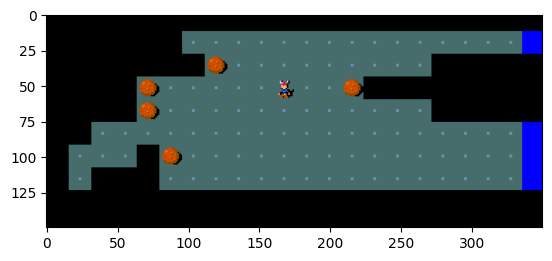

In [2]:
seeds = [8]
state, env = create_env(seeds)
plt.imshow(state['pixel'][100:250, 400:750])
game_map = state['chars']
game = state['pixel']
color_map = state['colors']

## Agent, boulder, river
Now that the environment is created we find the coordinates of the the agent, boulders and river. Once we have obtained all the coordinates we select the boulder to push and the river cell in which the boulder has to be pushed.

In [3]:
start = get_player_location(game_map)
boulders = get_boulder_locations(game_map, [])
river_positions = find_river(env,game_map, [])
print("Agent starting position: ", start, "Boulders positions: ", boulders, "River positions: ", river_positions)

Agent starting position:  (9, 35) Boulders positions:  [(8, 32), (9, 29), (9, 38), (10, 29), (12, 30)] River positions:  [(7, 46), (11, 46), (12, 46), (13, 46)]


We select the most convenient boulder to push into the the river, once it is computed we find the river cell in which the boulder has to be dropped.

In [4]:
coordinates_min_boulder = get_best_global_distance(start, boulders, river_positions)
temp = get_min_distance_point_to_points(coordinates_min_boulder[0],coordinates_min_boulder[1], river_positions)
final_position = tuple(temp[0])
print("Boulder to push: ", coordinates_min_boulder, "River cell of destination: ", final_position)

Boulder to push:  (9, 38) River cell of destination:  (7, 46)


# Path
In this section we use the classic A star algorithm to compute the path first from the boulder to the river, then from the agent to the boulder pushing positions.
The boulder pushing position is the cell in which the agent has to be to push the boulder in the correct direction.

TODO: talk about chebyshev and a star in general

We compute in this order:
* The path that the boulder has to follow to reach the correct river cell
* The correct pushing position of the boulder
* The path that agent has to follow to reach the pushing position

In [5]:
path_boulder_river = a_star(game_map, coordinates_min_boulder,final_position, True, False, get_optimal_distance_point_to_point)
pushing_position = position_for_boulder_push(coordinates_min_boulder, path_boulder_river[1])[1]
path_player_to_pushing_position = a_star(game_map, start,  pushing_position,False,False, get_optimal_distance_point_to_point)


After we have computed the path that the boulder has to do to reach the river, we have to derive from it the path that the agent has to do in order to follow the boulder pushing it. Finally we obtain the full path that the agent has to do to reach the river.

In [6]:
try:
    _, path_player_to_river = push_boulder_path(path_boulder_river)
    path_player_to_river = path_player_to_river[1:] # Remove the first element because the agent is already in the pushing position
    agent_full_path = path_player_to_pushing_position + path_player_to_river
    agent_full_path.append(path_boulder_river[-1]) # Add the river position so the agent steps where there was the river
except Exception as e:
    print("An error occurred:", str(e))


## Steps
In this section we translate the path obtained in actual actions and we execute the steps to push the boulder into the river.


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

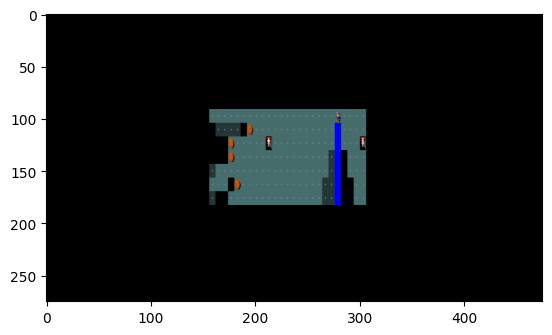

In [7]:
actions, names = actions_from_path(start, agent_full_path) 
plot_animated_sequence(env,game, game_map,actions[1:]) #Remove first action because it is the start position

## Finding the stairs
Now that the river should be crossable the agent can see, find and go torwards the stairs to complete is goal.
To evaluate if the agent completed is goal we use the reward system of MiniHack that for each step returns:
* 0.0 if the agent has not completed the goal
* -0.1 if the agent is stuck (The agent did a step but he stayied in the same position)
* 1 if the agent has stepped in the coordinates of the stairs

0.0
0.0
0.0
1.0
The agent reached the exit


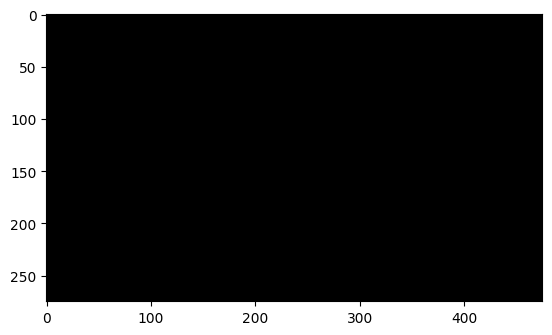

In [8]:
player_pos = get_player_location(game_map)
exit_pos = find_stairs(env, game_map)

if(exit_pos is None):
    print("The agent doesn't see the stairs")
else:
    path_to_exit = a_star(game_map, player_pos, exit_pos, False, False, get_optimal_distance_point_to_point)
    actions_to_exit,names = actions_from_path(player_pos, path_to_exit)
    rewards = plot_animated_sequence(env,game, game_map,actions_to_exit[1:]) 

if(rewards[-1] == 1):
    print("The agent reached the exit")
else:
    print("The agent didn't reach the exit")

# Solution 2: Online A star
We show now our custom solution "Online A star" which combines the power of the A star algorithms with the knowledge base logic

## Logic 
TODO: explain what the logic does

## Environment
We create the environment again, this time we don't give a fixed seed so that the environment is generated randomly at each execution.

In [1]:
import gym
import minihack
import numpy as np
import math
import matplotlib.pyplot as plt
import IPython.display as display
from typing import Tuple, List
from utils import *
from algorithms import *
from logic import *
from evaluation import *

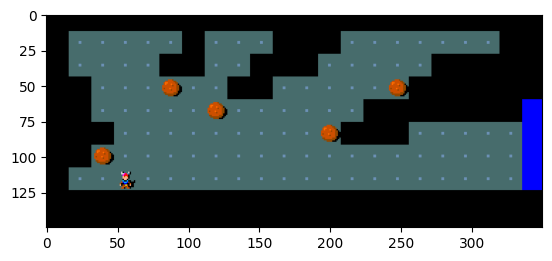

In [2]:
state, env = create_env()
plt.imshow(state['pixel'][100:250, 400:750]) 
game_map = state['chars']
game = state['pixel']
color_map = state['colors']

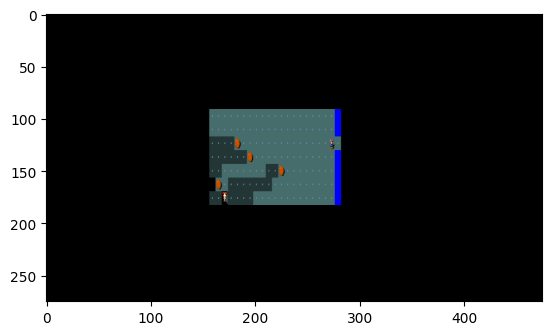

In [3]:
black_list_boulder  = []
obs, current_river_target, len = push_one_boulder_into_river(state, env, black_list_boulder, plot=True)
while current_river_target is None or obs['chars'][current_river_target] == ord("}"):
    obs, current_river_target, len = push_one_boulder_into_river(obs, env, black_list_boulder, plot=True)

game_map = obs['chars']
game_gui = obs['pixel']

#Step into the river
player_pos = get_player_location(game_map)
action, name = action_map(player_pos, current_river_target)
obs, _,_,_ = env.step(action)


0.0
0.0
0.0
1.0
The agent reached the exit


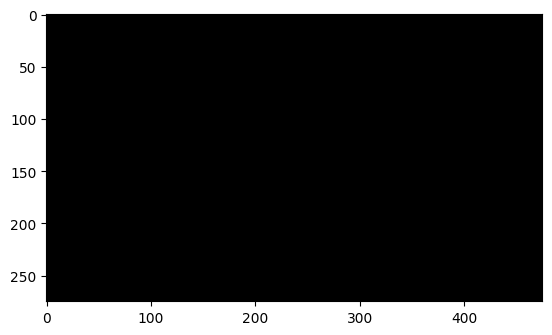

In [4]:
#Go to the stairs
game_map = obs['chars']
game_gui = obs['pixel']

player_pos = get_player_location(game_map)
exit_pos = get_exit_location(game_map)

path_to_exit = a_star(game_map, player_pos, exit_pos, False, False, get_optimal_distance_point_to_point)
actions_to_exit,names = actions_from_path(player_pos, path_to_exit[1:])
rewards = plot_animated_sequence(env, game_gui, game_map, actions_to_exit)

if(rewards[-1] == 1):
    print("The agent reached the exit")

# Evaluation
In this section we perform multiple trials on the two solutions showing the metrics:
* The percentage of successfully completed games out of n trials
* The average number of steps done on successfull games
* The execution time on successfull games

In [5]:
test_classic_a_star(100, 1) # number of games, trials


Starting test: A* classic

Successfully completed:  56 / 100  =  56.00000000000001 %
Average number of steps:  17.142857142857142
Average time per success:  0.07232209188597542 

Average total succesfully completed:  56.00000000000001 %
Average total steps:  17.142857142857142
Average total time:  0.07232209188597542 



In [6]:
test_online_a_star(100, 1)


Starting test: A* online

Successfully completed:  99 / 100  =  99.0 %
Average number of steps:  20.717171717171716
Average time per success:  0.10613737925134524 

Average total succesfully completed:  99.0 %
Average total steps:  20.717171717171716
Average total time:  0.10613737925134524 



## Results
This are the results that we have obtained executing x games for y trials

TODO: show image with the results (the same of the presentation with updated results)


TODO: write comments on the results

## TorchBeast
https://minihack.readthedocs.io/en/latest/agents/torchbeast.html \
https://wandb.ai/minihack/minihack-navigation/groups/River-Narrow-RIDE/?workspace=user- \

# Conclusions

# Appendix

### Teamwork 
After we have chosen a this project with unanimity, for the first weeks we splitted the work in two main task "Path" and "Logic". This has made easy to work with a pair programming approach in 2 groups, communicating the functions required from each other. Following this organization really boosted the initial productivity. Finally we did a merge of the "Path" and "Logic" modules. \
From this point we did a meeting every week to updated a pool of task available so that each member could contribute indipendently, going back to the pair programming approach just for the hardest problems. \
For the presentation we splitted in exact equal parts the slides and time of speech.


### Github

### Relationship with the course ???